# Exploración: riesgos_historicos_estudiante_pregrado_anonymized

Notebook para explorar el archivo de datos de riesgos históricos de estudiantes de pregrado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from ydata_profiling import ProfileReport
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline


In [2]:
df = pd.read_parquet('../data/riesgos_historicos_estudiante_pregrado_anonymized.parquet')


In [3]:
print(f"Dimensiones: {df.shape}")
print(f"Número de filas: {df.shape[0]:,}")
print(f"Número de columnas: {df.shape[1]}")
print(f"\nMemoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


In [4]:
print("\nColumnas:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col} ({df[col].dtype})")


In [5]:
df.head()


In [6]:
df.info()


In [7]:
df.describe()


In [8]:
print("\nValores nulos por columna:")
null_counts = df.isnull().sum()
null_pct = (null_counts / len(df) * 100).round(2)
null_df = pd.DataFrame({'Nulos': null_counts, 'Porcentaje': null_pct})
print(null_df[null_df['Nulos'] > 0].sort_values('Nulos', ascending=False))


In [9]:
#profile = ProfileReport(df, title="Reporte de Profiling - Riesgos Históricos Estudiante Pregrado", minimal=False)


## Análisis Univariado - Variables Categóricas

In [10]:
cat_cols = df.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
print(f"Variables categóricas encontradas: {len(cat_cols)}")
print(cat_cols)


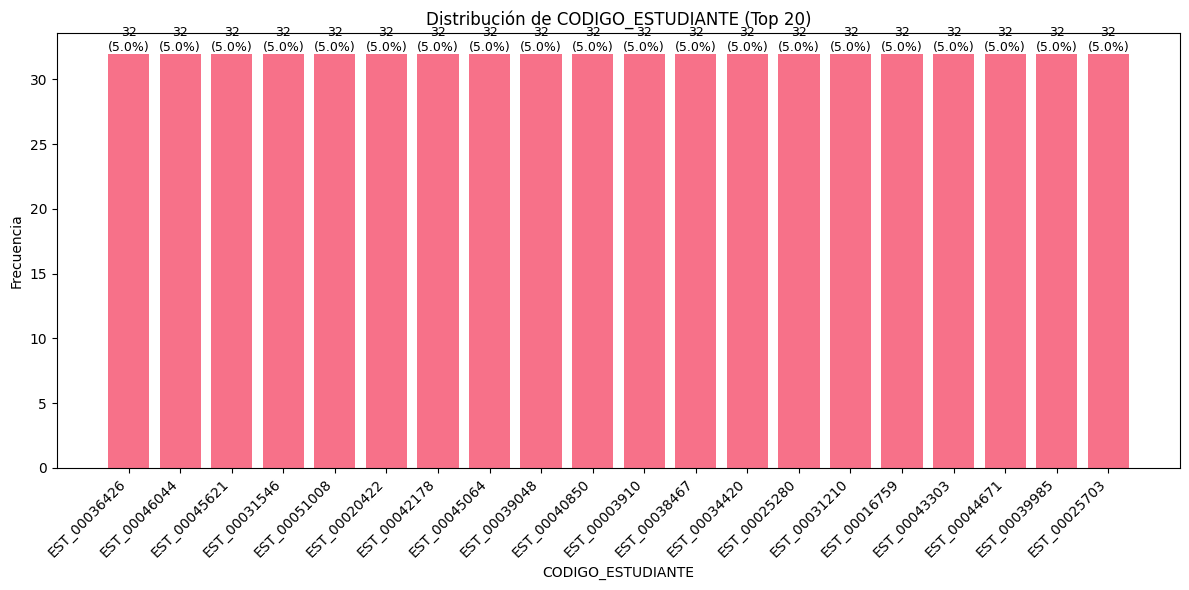

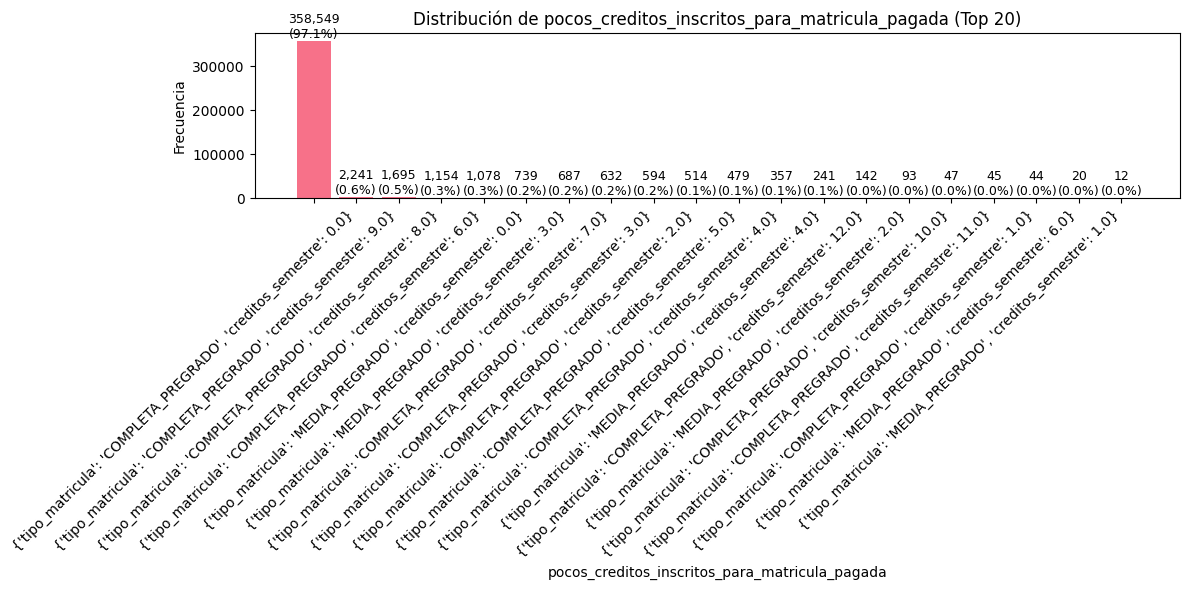

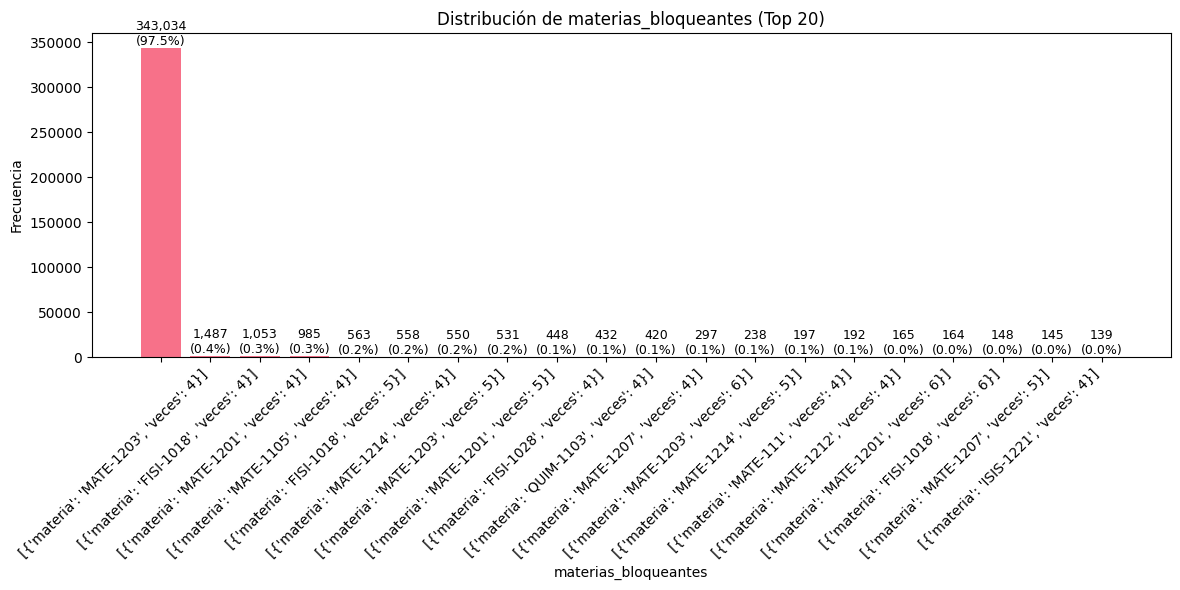

In [11]:
for col in cat_cols:
    value_counts = df[col].value_counts(dropna=False)
    if len(value_counts) > 20:
        value_counts = value_counts.head(20)
        title_suffix = " (Top 20)"
    else:
        title_suffix = ""
    percentages = (value_counts / value_counts.sum() * 100)
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(value_counts)), value_counts.values)
    for i, (bar, count, pct) in enumerate(zip(bars, value_counts.values, percentages.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=9)
    ax.set_title(f'Distribución de {col}{title_suffix}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"DISTRIBUCIÓN DE: {col}{title_suffix}")
    print(f"{'='*80}")
    dist_df = pd.DataFrame({
        'Categoría': value_counts.index,
        'Conteo': value_counts.values,
        'Porcentaje': percentages.values
    })
    dist_df['Porcentaje'] = dist_df['Porcentaje'].apply(lambda x: f"{x:.2f}%")
    dist_df['Conteo'] = dist_df['Conteo'].apply(lambda x: f"{x:,}")
    print(dist_df.to_string(index=False))
    print(f"\nTotal: {value_counts.sum():,} registros")
    print(f"{'='*80}\n")


## Análisis Univariado - Variables Numéricas

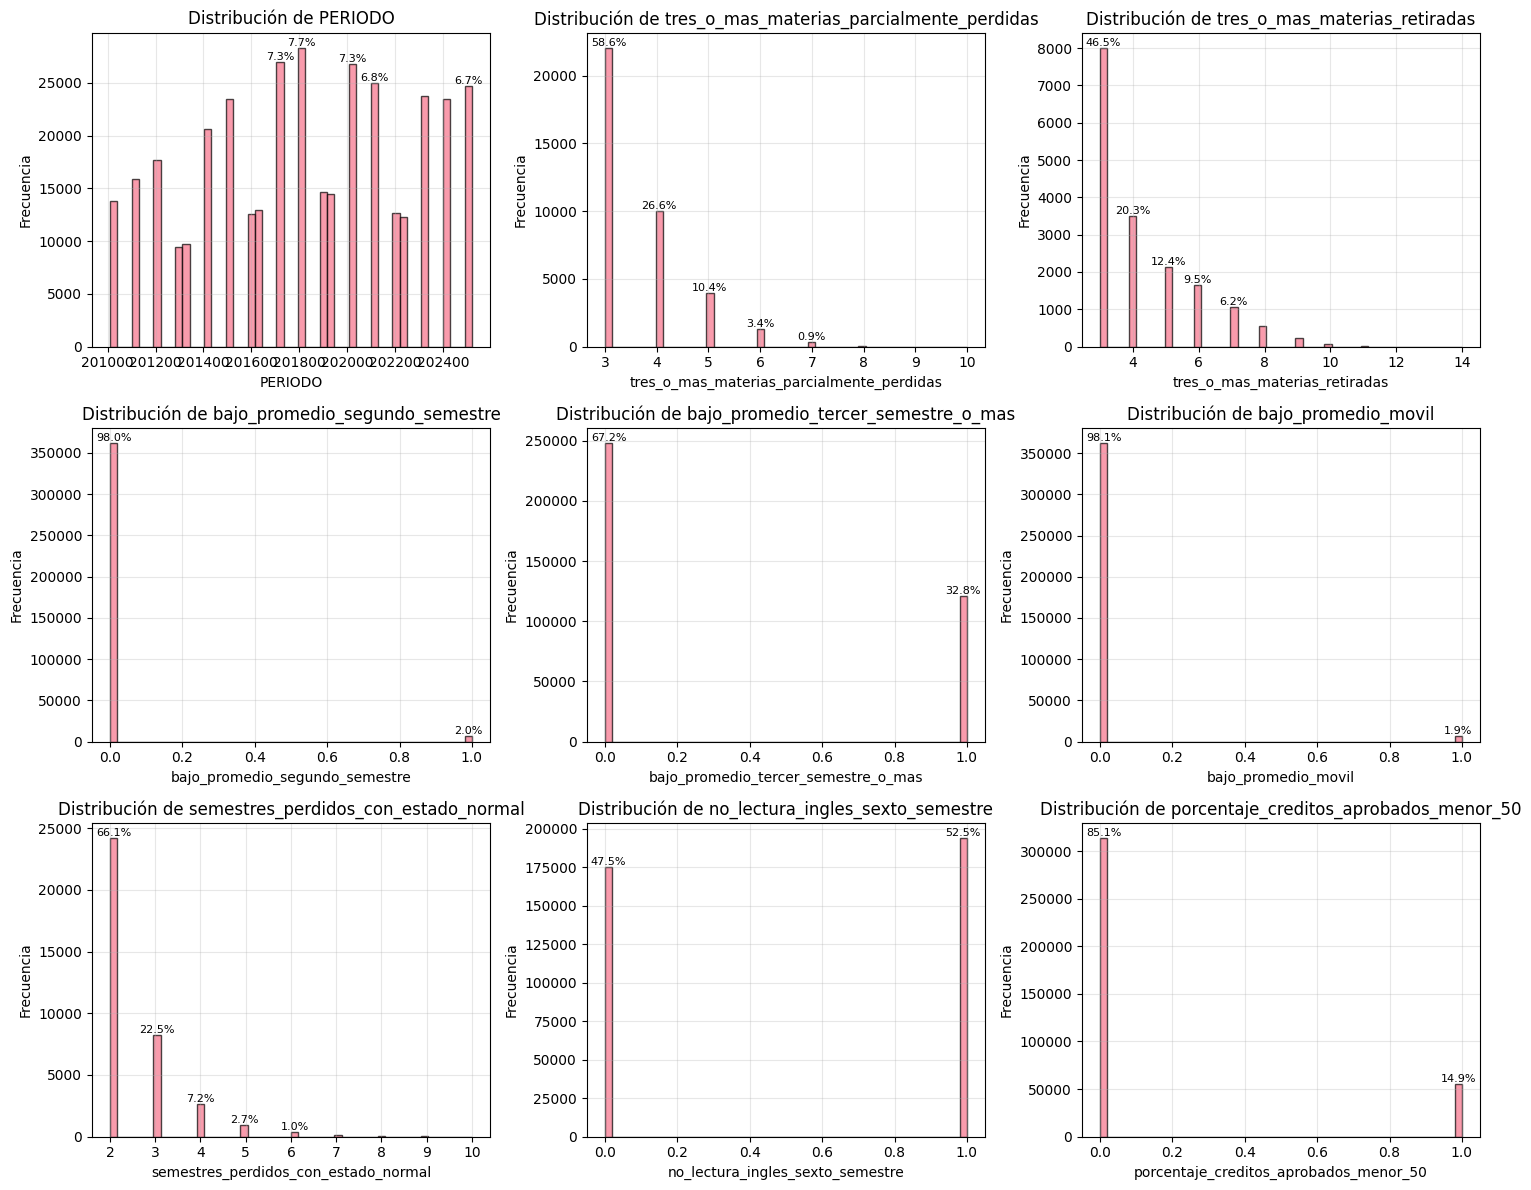

In [12]:
num_cols = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()
print(f"Variables numéricas encontradas: {len(num_cols)}")
print(num_cols)
if len(num_cols) > 0:
    n_cols = 3
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if len(num_cols) > 1 else [axes]
    for idx, col in enumerate(num_cols):
        data = df[col].dropna()
        n, bins, patches = axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
        total = len(data)
        bin_heights = list(zip(n, range(len(n))))
        bin_heights.sort(reverse=True)
        top_bins = bin_heights[:min(5, len(bin_heights))]
        for height, bin_idx in top_bins:
            if height > 0:
                pct = (height / total) * 100
                bin_center = (bins[bin_idx] + bins[bin_idx + 1]) / 2
                axes[idx].text(bin_center, height, f'{pct:.1f}%',
                             ha='center', va='bottom', fontsize=8)
        axes[idx].set_title(f'Distribución de {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].grid(True, alpha=0.3)
    for idx in range(len(num_cols), len(axes)):
        axes[idx].set_visible(False)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print("ESTADÍSTICAS DE DISTRIBUCIONES NUMÉRICAS")
    print(f"{'='*80}")
    for col in num_cols:
        data = df[col].dropna()
        print(f"\n{col}:")
        print(f"  Total registros: {len(data):,}")
        print(f"  Valores únicos: {data.nunique():,}")
        print(f"  Mínimo: {data.min():,.2f}")
        print(f"  Máximo: {data.max():,.2f}")
        print(f"  Media: {data.mean():,.2f}")
        print(f"  Mediana: {data.median():,.2f}")
        print(f"  Desv. Estándar: {data.std():,.2f}")
        
        percentiles = data.value_counts().head(10)
        if len(percentiles) > 0:
            print(f"\n  Top 10 valores más frecuentes:")
            for val, count in percentiles.items():
                pct = (count / len(data)) * 100
                print(f"    {val:,.2f}: {count:,} registros ({pct:.2f}%)")
    print(f"\n{'='*80}\n")
else:
    print("No hay variables numéricas para graficar.")


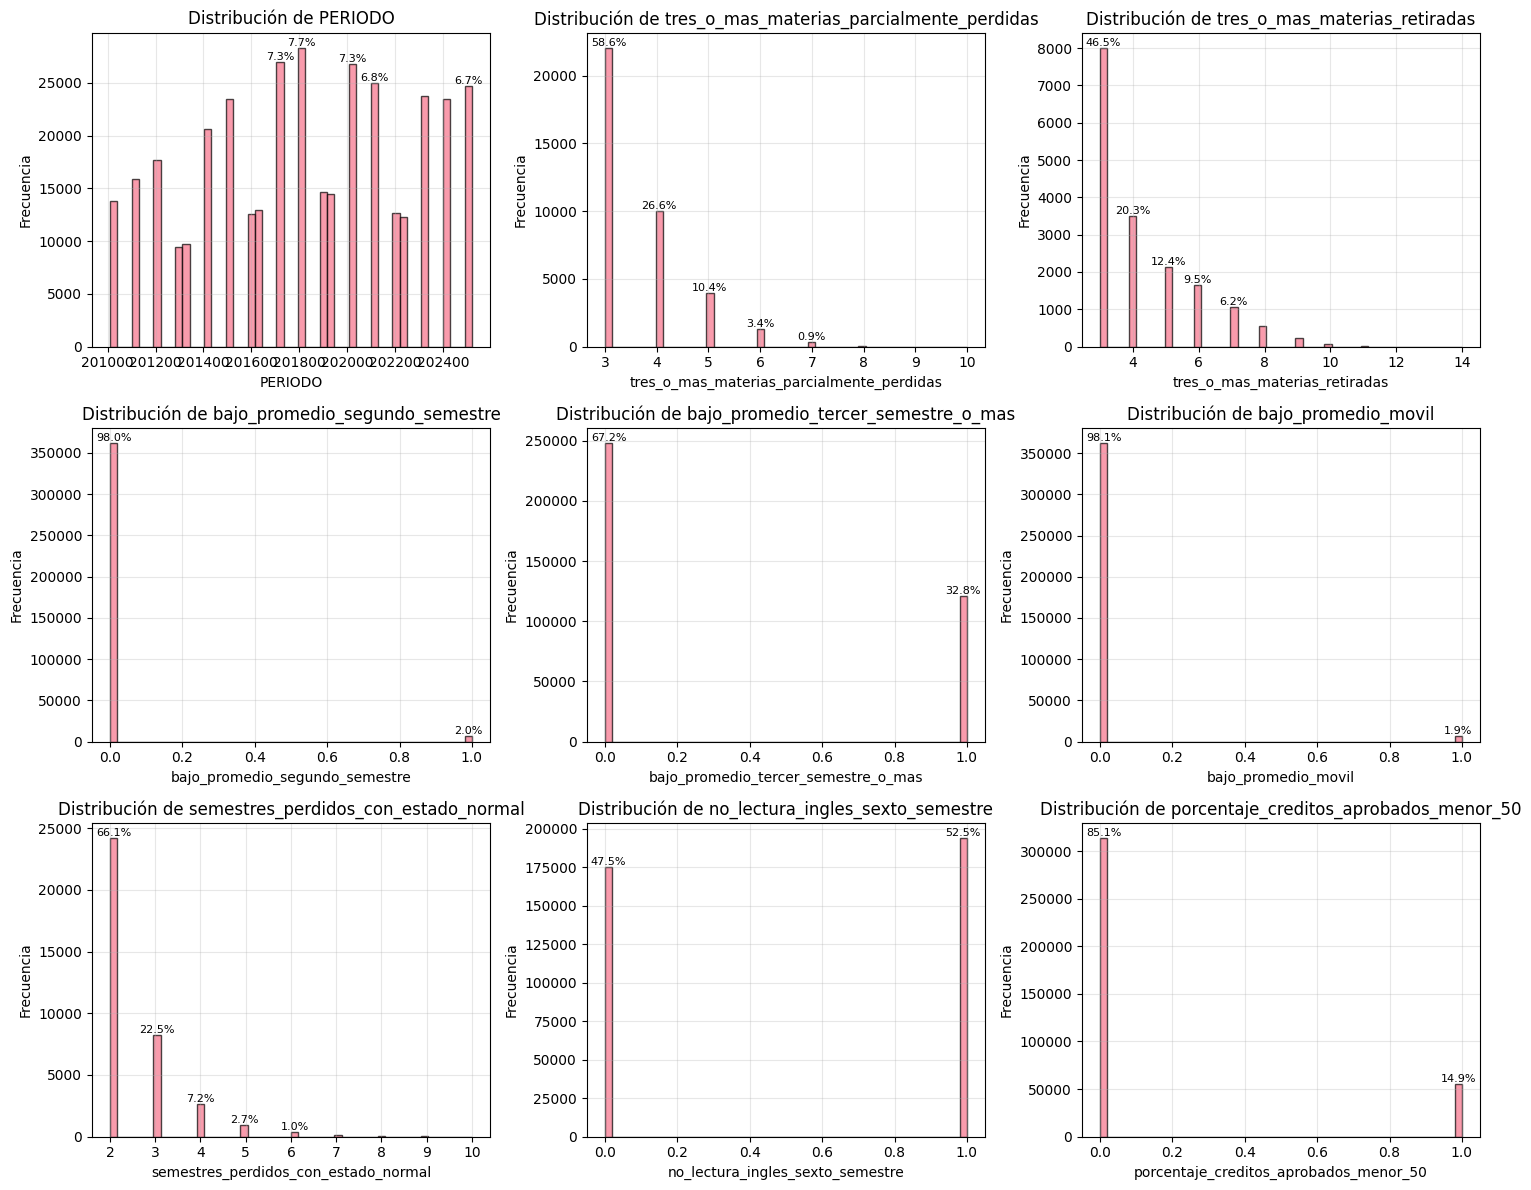

In [13]:
if len(num_cols) > 0:
    n_cols = 3
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if len(num_cols) > 1 else [axes]
    for idx, col in enumerate(num_cols):
        data = df[col].dropna()
        n, bins, patches = axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
        total = len(data)
        bin_heights = list(zip(n, range(len(n))))
        bin_heights.sort(reverse=True)
        top_bins = bin_heights[:min(5, len(bin_heights))]
        for height, bin_idx in top_bins:
            if height > 0:
                pct = (height / total) * 100
                bin_center = (bins[bin_idx] + bins[bin_idx + 1]) / 2
                axes[idx].text(bin_center, height, f'{pct:.1f}%',
                             ha='center', va='bottom', fontsize=8)
        axes[idx].set_title(f'Distribución de {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].grid(True, alpha=0.3)
    for idx in range(len(num_cols), len(axes)):
        axes[idx].set_visible(False)
    plt.tight_layout()
    plt.show()
else:
    print("No hay variables numéricas para graficar.")


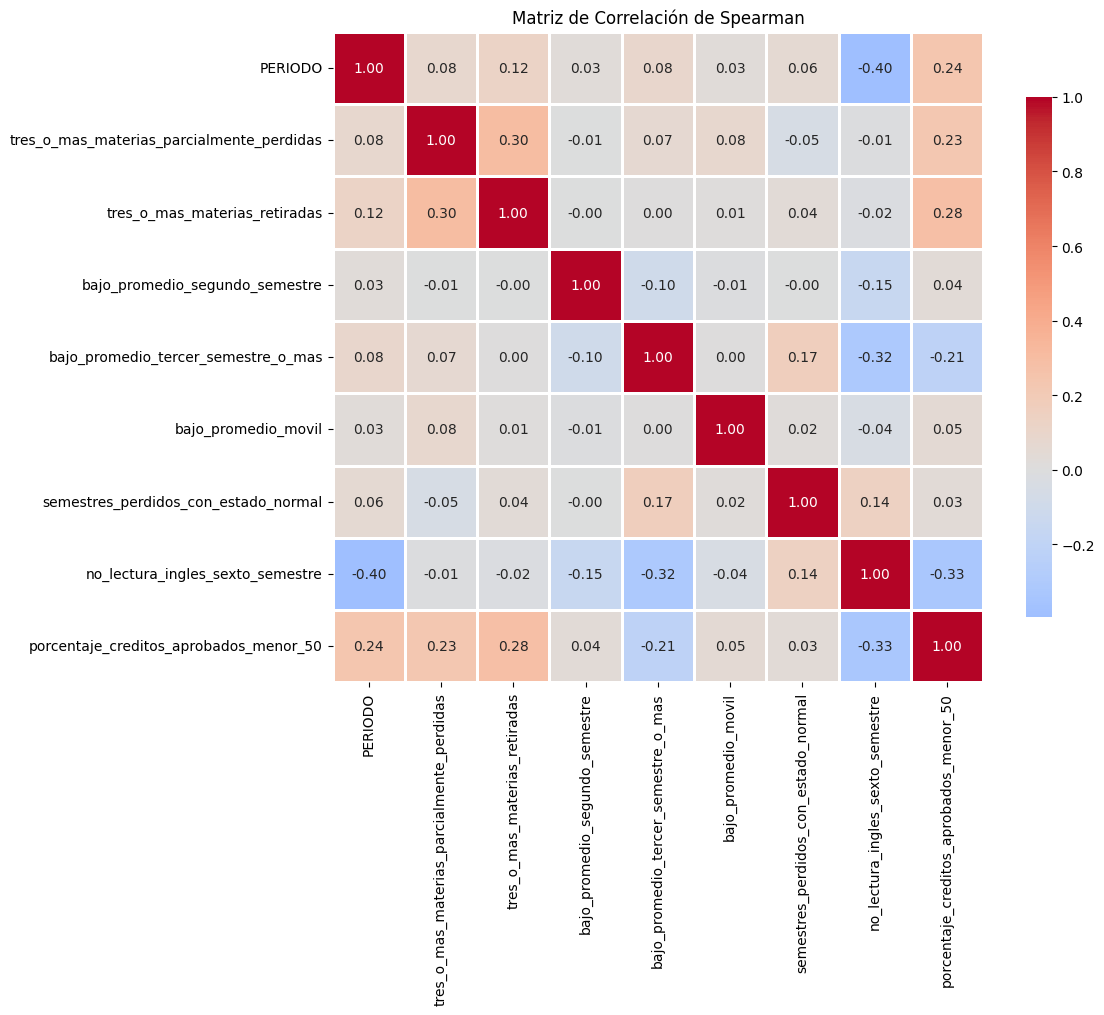

In [14]:
if len(num_cols) > 1:
    corr_matrix = df[num_cols].corr(method='spearman')
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Matriz de Correlación de Spearman')
    plt.tight_layout()
    plt.show()
    print("\nCorrelaciones fuertes (|r| > 0.7):")
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                print(f"{corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")
else:
    print("Se necesitan al menos 2 variables numéricas para calcular correlaciones.")


## Análisis Multivariado - Pairplot

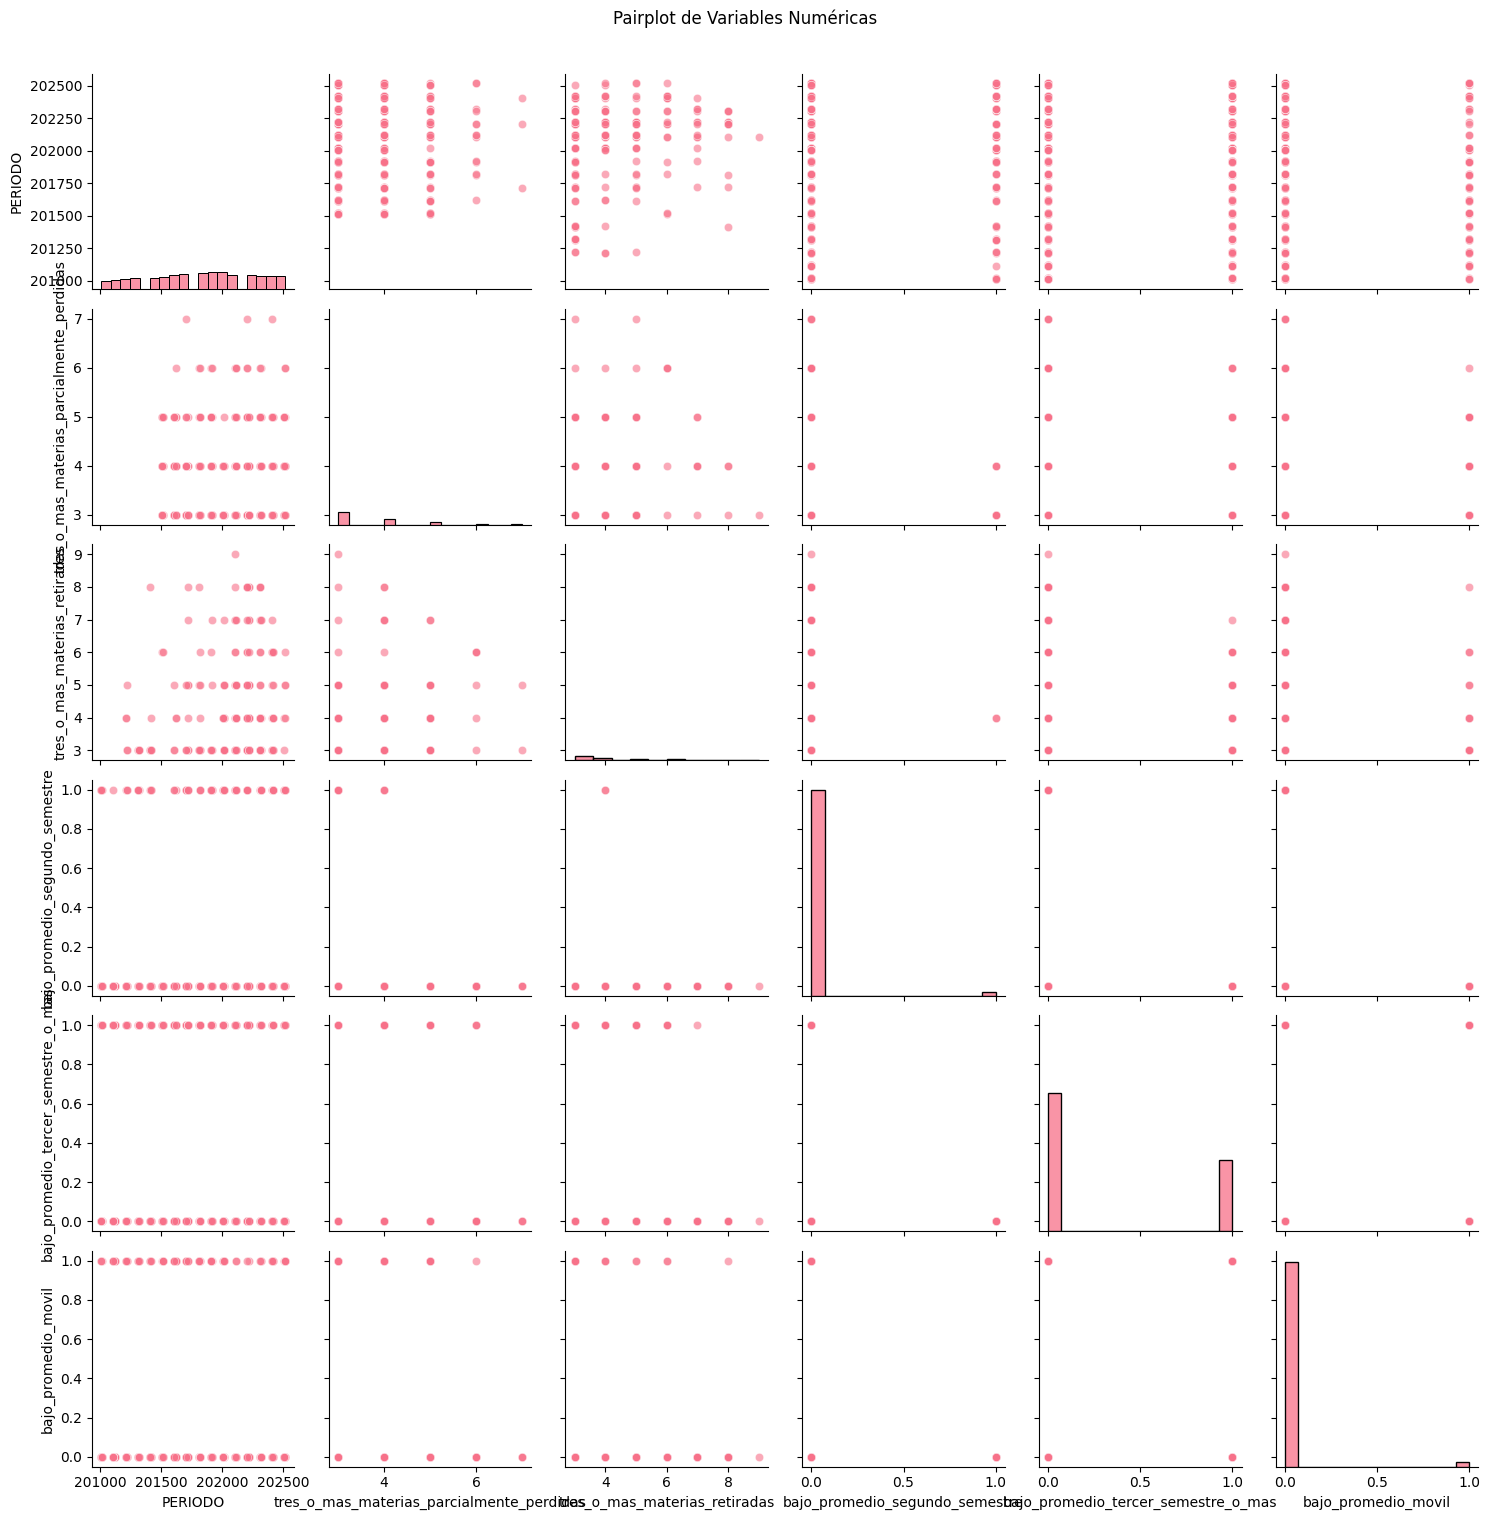

In [15]:
if len(num_cols) > 1:
    cols_to_plot = num_cols[:6]
    print(f"Generando pairplot para: {cols_to_plot}")
    sample_size = min(5000, len(df))
    df_sample = df[cols_to_plot].sample(n=sample_size, random_state=42)
    sns.pairplot(df_sample, diag_kind='hist', plot_kws={'alpha': 0.6})
    plt.suptitle('Pairplot de Variables Numéricas', y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("Se necesitan al menos 2 variables numéricas para generar pairplot.")


## Análisis Multivariado - Variables Categóricas

In [18]:
cat_cols_filtered = []
for col in cat_cols:
    try:
        if df[col].nunique() < 20:
            cat_cols_filtered.append(col)
    except TypeError:
        print(f"Omitiendo columna '{col}' por contener tipos no hashables (ej. diccionarios)")
        continue

cat_cols_filtered = cat_cols_filtered[:3]

if len(cat_cols_filtered) >= 2:
    print(f"\nAnalizando relaciones entre: {cat_cols_filtered}")
    for i in range(len(cat_cols_filtered)):
        for j in range(i+1, len(cat_cols_filtered)):
            col1, col2 = cat_cols_filtered[i], cat_cols_filtered[j]
            print(f"\n{'='*60}")
            print(f"Tabla cruzada: {col1} vs {col2}")
            print(f"{'='*60}")
            crosstab = pd.crosstab(df[col1], df[col2], margins=True)
            print(crosstab)
            crosstab_no_margins = pd.crosstab(df[col1], df[col2])
            plt.figure(figsize=(10, 6))
            sns.heatmap(crosstab_no_margins, annot=True, fmt='d', cmap='YlOrRd')
            plt.title(f'Heatmap: {col1} vs {col2}')
            plt.tight_layout()
            plt.show()
else:
    print("No hay suficientes variables categóricas para análisis multivariado.")
